In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# def rgb2gray(rgb, norm=True):
#     # Convert RGB to grayscale using the standard formula
#     gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])  # RGB to grayscale
#     if norm:
#         # Normalize the grayscale image to range [-1, 1]
#         gray = gray / 128.0 - 1.0
#     return gray

# Function to preprocess the state (convert to grayscale, resize to 48x48, and round pixel values)
def preprocess_state(state, size=(96, 96)):
    # Convert the state (RGB) to grayscale (single channel)
    # state_gray = rgb2gray(state)
    state_gray = state

    
    # Resize the grayscale image to 48x48
    state_resized = cv2.resize(state_gray, size, interpolation=cv2.INTER_AREA)
    
    # Round the pixel values to 8 decimal places (this can be considered a form of compression)
    state_resized = np.round(state_resized, 16)
    
    return state_resized

/opt/miniconda3/envs/myenv38/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


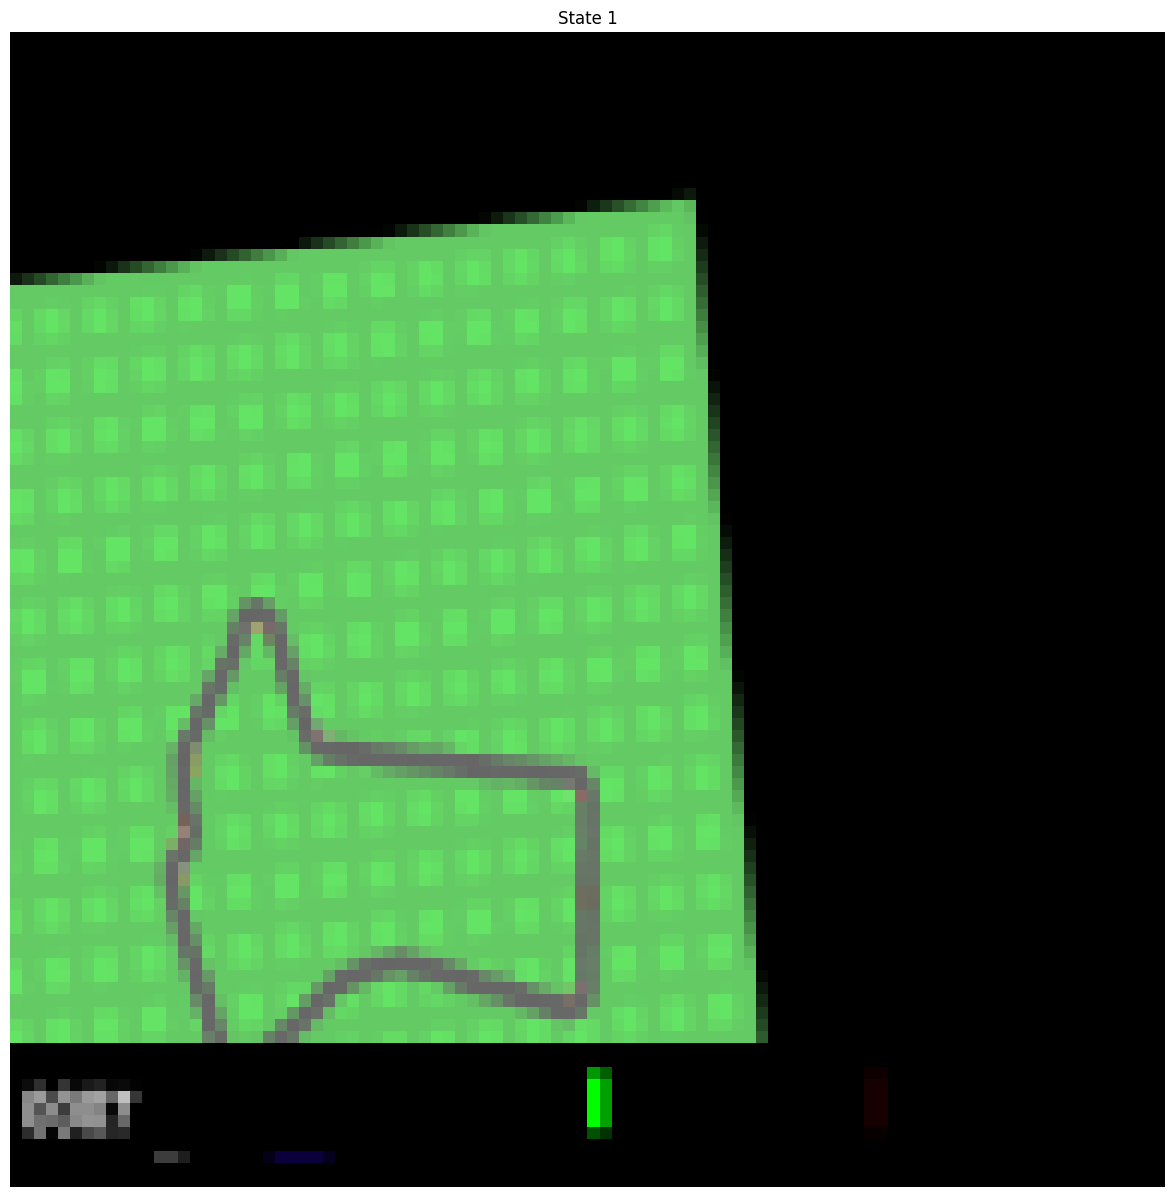

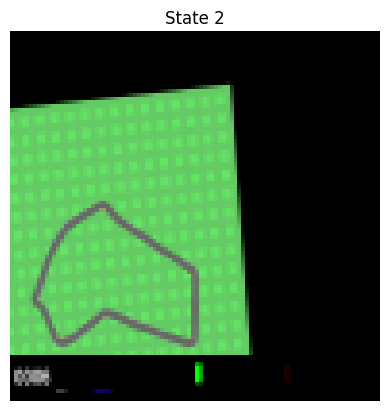

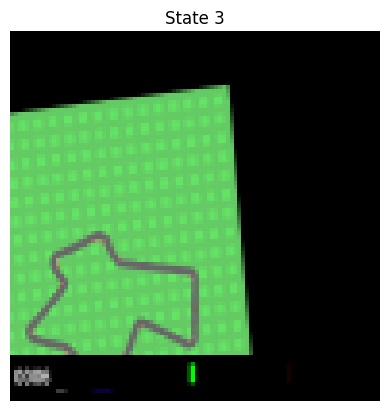

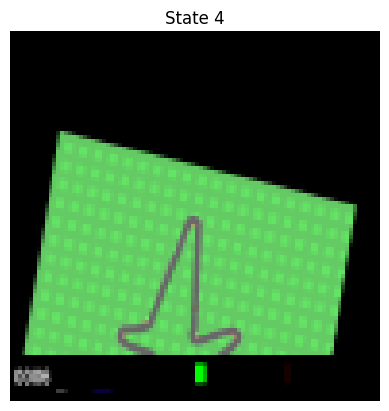

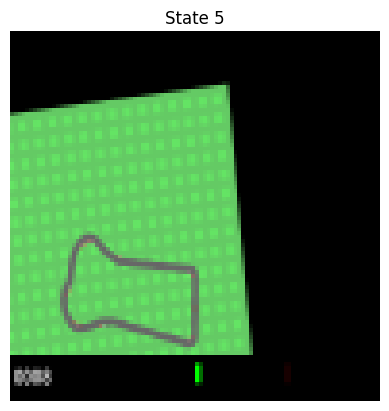

In [3]:
# Create the CarRacing environment
env = gym.make('CarRacing-v2')

# Function to plot the state
def plot_state(state, title="State"):
    plt.imshow(state)
    plt.title(title)
    plt.axis('off')  # Hide axes for clean visualization
    plt.show()

# Run the environment and collect the last 5 states
states = []
for _ in range(5):
    state = env.reset()  # Reset the environment and get the initial state
    done = False
    while not done:
        action = env.action_space.sample()  # Random action (or choose a policy here)
        

        # for i in range(0):
        #     state, reward, done, truncated, info = env.step(action)

        state, reward, done, truncated, info = env.step(action)
        
        # Preprocess the state (round pixel values to 8 decimal places)
        processed_state = preprocess_state(state)
        
        # Store the processed state for later plotting
        states.append(processed_state)
        break  # We only need the first step of each episode for plotting

# Close the environment
env.close()

# Plot the last 5 states
plt.figure(figsize=(15, 15))  # Adjust the figure size
for i, state in enumerate(states):
    # ax = plt.subplot(1, 5, i + 1)
    plot_state(state, title=f"State {i+1}")


# ***MAking a Custom env***

import gym
from gym import spaces
import numpy as np

# Assume the Zcar simulator is already built. For this example, we'll mock up the behavior
# using random actions and rewards. You will need to replace this with the actual Zcar simulation logic.

class ZcarEnv(gym.Env):
    def __init__(self):
        super(ZcarEnv, self).__init__()

        # Action space: Define the actions the agent can take. 
        # Assume 2 continuous actions: steering and acceleration.
        # Steering range: -1 (left) to 1 (right)
        # Acceleration range: -1 (brake) to 1 (accelerate)
        self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), high=np.array([1.0, 1.0]), dtype=np.float32)

        # Observation space: Assume a 96x96 RGB image (height x width x channels)
        # This could also be positions and velocities if the game is more simplistic
        self.observation_space = spaces.Box(low=0, high=255, shape=(96, 96, 3), dtype=np.uint8)

        # Initialize the state (image or other relevant variables)
        self.state = np.zeros((96, 96, 3), dtype=np.uint8)

        # Simulation parameters (like car position, velocity, etc.)
        self.car_position = np.array([0.0, 0.0])  # X, Y position
        self.car_velocity = 0.0  # Speed of the car
        self.car_angle = 0.0  # Steering angle
        self.done = False
        self.step_count = 0

    def reset(self):
        """
        Reset the environment to an initial state and return the first observation.
        """
        # Reset the car position, velocity, and other state variables
        self.car_position = np.array([0.0, 0.0])  # Start at the center of the track
        self.car_velocity = 0.0
        self.car_angle = 0.0
        self.done = False
        self.step_count = 0

        # Reset the image or other state representations (in this case, just a blank image)
        self.state = np.zeros((96, 96, 3), dtype=np.uint8)

        return self.state

    def step(self, action):
        """
        Take an action in the environment and return the new state, reward, done, and info.
        """
        # Unpack the action (steering and acceleration)
        steering, acceleration = action

        # Apply the action to update the car's state
        self.car_angle += steering  # Update car angle (steering)
        self.car_velocity += acceleration  # Update car velocity (acceleration)
        self.car_position += np.array([np.cos(self.car_angle), np.sin(self.car_angle)]) * self.car_velocity  # Move car

        # Update the state (this is where you would normally update the image or other state representation)
        # For simplicity, we'll keep the image the same, but you'd update it based on the car's new state
        self.state = np.zeros((96, 96, 3), dtype=np.uint8)  # This should ideally be a real image from the simulation

        # Define the reward and done conditions:
        reward = -0.1  # Penalize for each step taken (encourages faster completion)
        done = False

        # If the car goes off track or completes a lap (you would need to implement these conditions)
        if self.car_position[0] < -10 or self.car_position[0] > 10 or self.car_position[1] < -10 or self.car_position[1] > 10:
            done = True  # End episode if car goes out of bounds

        # Track how many steps the agent has taken
        self.step_count += 1
        if self.step_count > 1000:  # You could set an upper limit for the number of steps
            done = True

        return self.state, reward, done, {}

    def render(self, mode='human'):
        """
        Visualize the environment. This could render an image or output some other visualization.
        """
        # For now, we will just print the car's position and state
        print(f"Car position: {self.car_position}, Velocity: {self.car_velocity}, Angle: {self.car_angle}")

    def close(self):
        """
        Clean up any resources if needed when the environment is closed.
        """
        pass

# Example usage with Stable Baselines3:

from stable_baselines3 import PPO

# Create the Zcar environment
env = ZcarEnv()

# Initialize the PPO agent (or another RL agent)
model = PPO('CnnPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=1e5)

# Save the trained model
model.save("ppo_zcar")

# Test the trained model
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()  # Optionally visualize the environment

